In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.simplefilter("ignore")
%matplotlib inline

In [105]:
# load the raw data in a pandas dataframe
df_raw = pd.read_csv("./drinking_water_potability.csv")
df_raw.columns
df_raw = df_raw.drop(['Sulfate', 'Organic_carbon', 'Trihalomethanes', 'Turbidity'], axis=1)



In [106]:
# Check for missing data
df_raw.isna().sum()

ph              491
Hardness          0
Solids            0
Chloramines       0
Conductivity      0
Potability        0
dtype: int64

39.01 % of samples are potable (1)


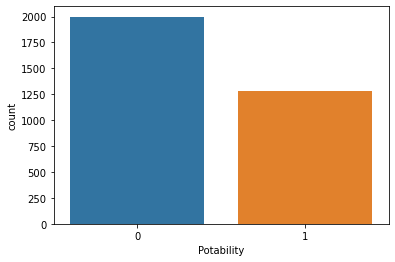

In [107]:
# view distribution
sns.countplot(x=df_raw["Potability"])

print(f'{df_raw.Potability[df_raw.Potability==1].count()/df_raw.Potability.count()*100:.2f} % of samples are potable (1)')

<AxesSubplot:>

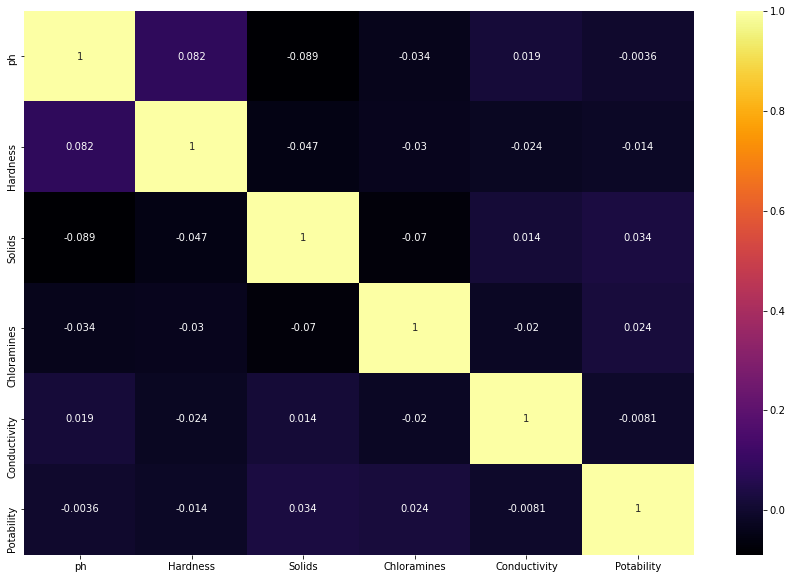

In [108]:
# Correlation matrix for dataset
plt.figure(figsize=(15,10))
sns.heatmap(df_raw.corr(), annot=True, cmap="inferno")

In [109]:
# Function to fill in missing data
def fill_nan(df):
    for index, column in enumerate(df.columns[:9]):
        # print(index, column)
        df[column] = df[column].fillna(df.groupby('Potability')[column].transform('mean'))
    return df
 

In [110]:
df = fill_nan(df_raw)

df.isna().sum() 

ph              0
Hardness        0
Solids          0
Chloramines     0
Conductivity    0
Potability      0
dtype: int64

In [111]:
# Splitting
X = df.drop(['Potability'], axis = 1)
y = df['Potability']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=18, stratify=y) #stratify=y
real_data = [
    [6.8, 200, 513, .25, 1045],
    [6.8, 250, 2, 0, 5],
    [6.8, 150, 480, .1, 1015],
    [6.8, 100, 540, 0, 1110],
    [7.6, 250, 620, .25, 1220],
    [6.8, 150, 540, 0, 1090],
    [7.2, 200, 565, .4, 1130],
    [7.6, 150, 620, .5, 1330]
]
real_df = pd.DataFrame(real_data)
X_new = X_test.append(real_data)
# Balancing data - oversampling minority
smt = SMOTE()
X_train, y_train = smt.fit_resample(X_train, y_train)
print(X_test)
# Scaling
sc = StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)


            ph    Hardness        Solids  Chloramines  Conductivity
893   9.055826  196.475899  20226.287940     5.838594    342.359411
3000  6.931244  207.588954  24359.470410     7.222004    477.062975
2765  7.073783  161.250331  23469.220870     8.392832    448.787964
2047  7.459124  195.028717  33173.499410     7.551374    534.166997
996   6.836225  166.742962  24293.172660     6.861235    390.804955
...        ...         ...           ...          ...           ...
733   9.239440  212.569076  14829.624210     7.172920    575.421968
3087  4.032061  200.067973  14720.544830     6.482679    519.213370
907   5.296579  220.080832  39537.086460     9.232766    393.388603
274   7.073783  156.520635  16146.157110     6.629599    629.281247
1205  4.429379  256.212565   8746.901717     9.010332    432.107935

[819 rows x 5 columns]


In [112]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
         "KNN": KNeighborsClassifier(),
         "Random Forest": RandomForestClassifier(),
         "Decision Tree": DecisionTreeClassifier(),
         "Naive Bayes": GaussianNB(),
         "ExtraTreesClassifier": ExtraTreesClassifier(),
         "xgb Classifier": XGBClassifier(),
         "CatBoostClassifier": CatBoostClassifier()}

In [113]:
# Function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
   
    """
   Fits and evaluates given machine learning models.
   models: a dict of different Scikit_Learn machine learning models
   X_train: training data (no labels)
   X_test: testing data (no labels)
   y_train: training labels
   y_test: test labels
   """ 
    # Set random seed
    np.random.seed(18)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit model to data
        model.fit(X_train, y_train)
        # Evaluate model and append its score to model_scores
        model_scores[name] = cross_val_score(model,
                                             X_test,
                                             y_test,
                                            scoring='accuracy',
                                            cv=5
                                            ).mean()

    return model_scores

In [96]:
model_scores = fit_and_score(models,X_train,X_test,y_train,y_test)

model_scores

[15:39:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

{'Logistic Regression': 0.6129432889420918,
 'KNN': 0.6043767768966033,
 'Random Forest': 0.7777944037109082,
 'Decision Tree': 0.7301436480622474,
 'Naive Bayes': 0.6300613496932514,
 'ExtraTreesClassifier': 0.6691306299566063,
 'xgb Classifier': 0.7924435133921891,
 'CatBoostClassifier': 0.7887700134670058}

<AxesSubplot:>

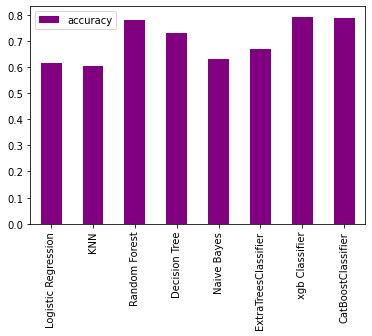

In [97]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar(color="purple")

In [116]:
#best performing model is xgb Classifyer, so thats what we will tune
from sklearn.model_selection import GridSearchCV
model = CatBoostClassifier()

# parameters = {'depth'           : [4,5,6,7,8,9,10],
#                  'learning_rate' : [0.03,0.04,.05,.06],
#                   'iterations'    : [50,60,70,80,90,100,120, 140]
#                  }

# Grid_CBC = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
# Grid_CBC.fit(X_train, y_train)
model.fit(X_train,y_train)
# print(" Results from Grid Search " )
# print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
# print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
# print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)
y_pred = model.predict(X_new)
y_pred

Learning rate set to 0.01646
0:	learn: 0.6895340	total: 2.37ms	remaining: 2.36s
1:	learn: 0.6863812	total: 5.09ms	remaining: 2.54s
2:	learn: 0.6829685	total: 8.14ms	remaining: 2.7s
3:	learn: 0.6805751	total: 9.8ms	remaining: 2.44s
4:	learn: 0.6786021	total: 12.2ms	remaining: 2.43s
5:	learn: 0.6757363	total: 14.7ms	remaining: 2.43s
6:	learn: 0.6723297	total: 16.2ms	remaining: 2.3s
7:	learn: 0.6682823	total: 17.9ms	remaining: 2.22s
8:	learn: 0.6658042	total: 20.6ms	remaining: 2.27s
9:	learn: 0.6649162	total: 22.2ms	remaining: 2.2s
10:	learn: 0.6616377	total: 24ms	remaining: 2.16s
11:	learn: 0.6604302	total: 25.6ms	remaining: 2.1s
12:	learn: 0.6566618	total: 27.9ms	remaining: 2.12s
13:	learn: 0.6557564	total: 31.6ms	remaining: 2.23s
14:	learn: 0.6531562	total: 34.6ms	remaining: 2.27s
15:	learn: 0.6523134	total: 36.8ms	remaining: 2.26s
16:	learn: 0.6515307	total: 38.8ms	remaining: 2.24s
17:	learn: 0.6507401	total: 41.9ms	remaining: 2.29s
18:	learn: 0.6484211	total: 44.6ms	remaining: 2.3s
1

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [99]:
# Classification report
print(classification_report(y_test, y_pred))
# print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.64      0.70       500
           1       0.55      0.69      0.61       319

    accuracy                           0.66       819
   macro avg       0.66      0.67      0.66       819
weighted avg       0.68      0.66      0.67       819



In [ ]:
real_data = [
    [6.8, 200, 513, .25, 1045],
    [6.8, 250, 2, 0, 5],
    [6.8, 150, 480, .1, 1015],
    [6.8, 100, 540, 0, 1110],
    [7.6, 250, 620, .25, 1220],
    [6.8, 150, 540, 0, 1090],
    [7.2, 200, 565, .4, 1130],
    [7.6, 150, 620, .5, 1330]
]
real_df = pd.DataFrame(real_data)

real_df = sc.transform(real_df)
real_pred = Grid_CBC.predict(real_df)
real_pred

array([1, 1, 0, 1, 1, 0, 0, 0])

In [100]:
# Helper function for plotting feature importance
def plot_features(columns, importances,n=20):
    df = (pd.DataFrame({"features": columns,
                       "feature_importances": importances})
         .sort_values("feature_importances", ascending=False)
         .reset_index(drop=True))
    # Plot dataframe
    fix, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Importance")
    ax.invert_yaxis()

Learning rate set to 0.01646
0:	learn: 0.6876347	total: 8.16ms	remaining: 8.15s
1:	learn: 0.6820961	total: 14.1ms	remaining: 7.03s
2:	learn: 0.6764028	total: 19.2ms	remaining: 6.4s
3:	learn: 0.6696618	total: 24.5ms	remaining: 6.11s
4:	learn: 0.6636683	total: 40.4ms	remaining: 8.03s
5:	learn: 0.6588819	total: 45.6ms	remaining: 7.56s
6:	learn: 0.6547241	total: 51.8ms	remaining: 7.34s
7:	learn: 0.6515353	total: 55.2ms	remaining: 6.85s
8:	learn: 0.6447824	total: 58.7ms	remaining: 6.46s
9:	learn: 0.6418558	total: 65ms	remaining: 6.43s
10:	learn: 0.6366623	total: 70ms	remaining: 6.29s
11:	learn: 0.6336575	total: 75ms	remaining: 6.18s
12:	learn: 0.6298453	total: 81.5ms	remaining: 6.19s
13:	learn: 0.6277868	total: 87.9ms	remaining: 6.19s
14:	learn: 0.6240203	total: 93.9ms	remaining: 6.16s
15:	learn: 0.6212401	total: 101ms	remaining: 6.21s
16:	learn: 0.6179899	total: 109ms	remaining: 6.3s
17:	learn: 0.6157040	total: 129ms	remaining: 7.04s
18:	learn: 0.6110443	total: 137ms	remaining: 7.05s
19:	l

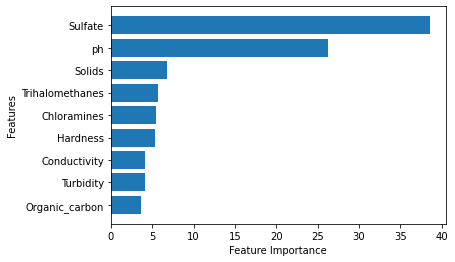

In [101]:
model = CatBoostClassifier()
model.fit(X_train, y_train)
plot_features(df.drop(['Potability'],axis=1).columns, model.feature_importances_)

In [18]:
print(model)


In [19]:
print(X_test[1])

[-0.11519544  0.35159616  0.2640627   0.07828638  0.64614758]


# Neural Network

In [45]:
from torch import nn
from torch.nn import functional as F

In [46]:
#define a model for binary classification

class Net(nn.Module):
  def __init__(self,input_shape):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_shape,32)
    self.fc2 = nn.Linear(32,64)
    # self.fc3 = nn.Linear(64, 128)
    self.fc3 = nn.Linear(64,1)  

  def forward(self,x):
      x = torch.relu(self.fc1(x))
      x = torch.relu(self.fc2(x))
      # x = torch.relu(self.fc3(x))
      x = torch.sigmoid(self.fc3(x))
      return x

In [47]:
import torch

In [48]:
# X_train, X_test, y_train, y_test
from torch.utils.data import Dataset, DataLoader

class dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]
 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]  
    def __len__(self):
        return self.length

trainset = dataset(X_train,y_train)#DataLoader
# print(trainset.x)
trainloader = DataLoader(trainset,batch_size=64,shuffle=False)

# testset = dataset(X_test,y_test)#DataLoader

# testloader = DataLoader(testset,batch_size=64,shuffle=False)


In [64]:
#forward loop
losses = []
accur = []

#hyper parameters
learning_rate = 0.01
epochs = 1000
# Model , Optimizer, Loss
model = Net(input_shape=X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate) #Stochastic Gradient Descent, could be ADAM if we wanted
loss_fn = nn.BCELoss() #binary cross entropy

for i in range(epochs):
    for j,(X_train,y_train) in enumerate(trainloader):
        # print(X_train)
        #calculate output
        output = model(X_train)
    
        #calculate loss
        loss = loss_fn(output,y_train.reshape(-1,1))
    
        #accuracy
        predicted = model(torch.tensor(X_test,dtype=torch.float32))
        acc = (predicted.reshape(-1).detach().numpy().round() == y_test).mean()    
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if i%50 == 0:
        losses.append(loss.detach().numpy())
        accur.append(acc)
        print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

epoch 0	loss : 0.3452165424823761	 accuracy : 0.3894993894993895
epoch 50	loss : 0.5387779474258423	 accuracy : 0.5848595848595849
epoch 100	loss : 0.40331465005874634	 accuracy : 0.5604395604395604
epoch 150	loss : 0.32484009861946106	 accuracy : 0.5567765567765568
epoch 200	loss : 0.28079479932785034	 accuracy : 0.5567765567765568
epoch 250	loss : 0.276517391204834	 accuracy : 0.5494505494505495
epoch 300	loss : 0.2830515205860138	 accuracy : 0.5409035409035409
epoch 350	loss : 0.26876479387283325	 accuracy : 0.5409035409035409
epoch 400	loss : 0.258884459733963	 accuracy : 0.5873015873015873
epoch 450	loss : 0.23750385642051697	 accuracy : 0.5934065934065934
epoch 500	loss : 0.2275397628545761	 accuracy : 0.5873015873015873
epoch 550	loss : 0.22717687487602234	 accuracy : 0.5921855921855922
epoch 600	loss : 0.22459088265895844	 accuracy : 0.5860805860805861
epoch 650	loss : 0.2154642641544342	 accuracy : 0.5811965811965812
epoch 700	loss : 0.17969615757465363	 accuracy : 0.584859584

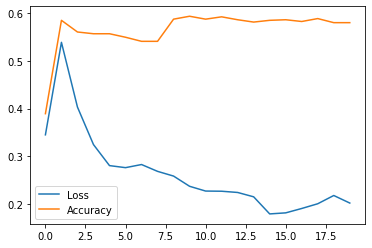

In [70]:
x = np.linspace(0,1000,1)
plt.plot(range(len(losses)), losses)
plt.plot(range(len(accur)), accur)
plt.legend(["Loss", "Accuracy"])
plt.show()